In [1]:
import glob
import os
import random
import shutil
import sys
from pathlib import Path

import numpy as np
import scipy.io
import torch

current_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前目录
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))  # 上一级目录
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, ".."))  # 上两级目录
sys.path.append(grandparent_dir)

import data_function
import metrics
import network
import tools
import utils

# from test_case.ex_main.model import *
# from test_case.ex_main.train_dataloader import getData
from ex_main1.model import *
from ex_main1.train_dataloader import getData
from utils.config_plot import *

In [2]:
ppath = "/home/hy/project/reid_task/ex_main1"

# Config
config_file_path = os.path.join(ppath, "config.py")
config = utils.common.read_config_file(config_file_path)

# Initialize a logger tool
logger = utils.logger.Logger(config.outputs_path)
logger.info("#" * 50)
logger.info(f"Task: {config.taskname}")
logger.info(f"Using device: {config.device}")
logger.info(f"Using data type: {config.dtype}")

# Set environment
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # The result cannot be reproduced when True

vis_outputs_path = "./results/vis/"
if os.path.exists(vis_outputs_path):
    shutil.rmtree(vis_outputs_path)

2024-06-10 23:06:51 INFO ##################################################
2024-06-10 23:06:51 INFO Task: ReID_Task
2024-06-10 23:06:51 INFO Using device: cuda
2024-06-10 23:06:51 INFO Using data type: torch.float32


In [3]:
def cosine_interpolation_node_selection(n):
    x = torch.zeros(n, 1)
    for i in range(n):
        x[i] = 1 / 2 * (1 - np.cos(i * torch.pi / (n - 1)))
    return x


def derivative_coefficient_of_Lagrange_interpolation(x):
    n = x.shape[0]
    A1 = torch.zeros(n, n)
    for i in range(n):
        for j in range(n):
            if i == j:
                a = 0
                for k in range(n):
                    if k != j:
                        a = a + 1 / (x[j] - x[k])
                A1[i, j] = a
            else:
                a = 1
                for k in range(n):
                    if k != j:
                        a = a * 1 / (x[j] - x[k])
                        if k != i:
                            a = a * (x[i] - x[k])
                A1[i, j] = a
    return A1

def newton_iteration_method(u0, G_func, esp=1e-4, max_iteration=100):
    current_iteration = 0
    uk = u0
    while True:
        G = G_func(uk)
        # Gu = torch.autograd.functional.jacobian(G_func, uk).squeeze()
        Gu = torch.func.jacrev(G_func, argnums=0)(uk).squeeze()
        uk1 = uk - torch.linalg.inv(Gu) @ G  # Iterative equation
        if current_iteration > max_iteration:
            break
        if torch.norm(uk1 - uk) < esp:
            return uk1
        current_iteration += 1
        uk = uk1
        

In [4]:
g = 9.8
l = 10
n = 5

t0 = 0
ts = 1
step = 0.01
n_step = (ts - t0) / step

第99区间, [tensor([0.9900])-tensor([1.])]


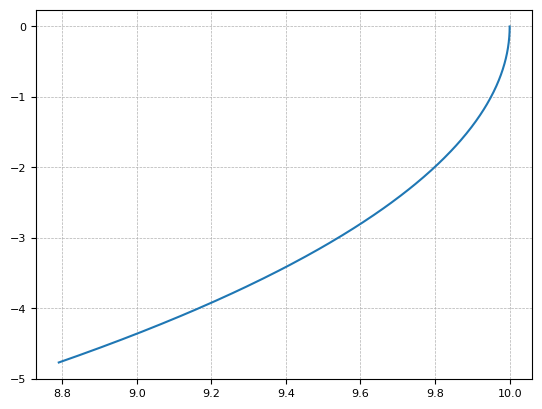

In [5]:
theta_list = []
u0_0 = torch.pi / 2
ut_0 = 0
t0_nodes = t0 + cosine_interpolation_node_selection(n) * step  #
for i in range(int(n_step)):
    # print("第{}区间".format(i))

    ti_nodes = t0_nodes + i * step
    # print(ti_nodes)
    A1 = derivative_coefficient_of_Lagrange_interpolation(ti_nodes)
    A2 = A1 @ A1

    if (i + 1) % 100 == 0:
        print("第{}区间, [{}-{}]".format(i, ti_nodes[0], ti_nodes[-1]))

    def G_func(u):
        G = torch.zeros(n, 1)
        temp = A2 @ u + g / l * torch.sin(u)

        G[0] = u[0] - u0_0
        G[1] = A1[0, :] @ u - ut_0
        G[2:] = temp[2:]
        return G

    u0 = torch.zeros(n, 1)
    uk = newton_iteration_method(u0, G_func)

    u0_0 = uk[-1]
    ut_0 = A1[-1, :] @ uk

    theta_list.append(uk.reshape(-1))

theta_np = utils.common.tensors_to_numpy(torch.stack(theta_list).squeeze()).reshape(
    -1, 1
)
theta_np.shape
plt.figure()
plt.plot(l * np.sin(theta_np), -l * np.cos(theta_np))

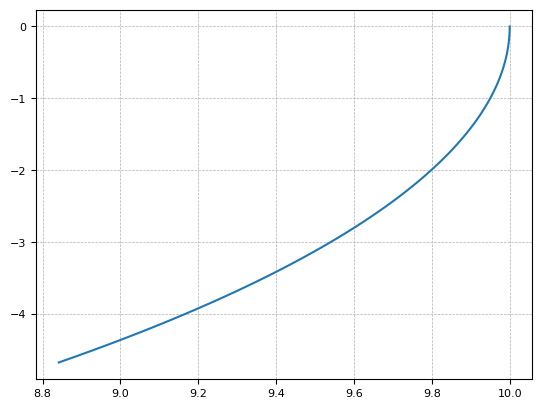

In [6]:
def eq_func(t, y):
    q, dq = y.chunk(2, dim=0)
    return torch.tensor([dq, -g / l * torch.sin(q)]).reshape(2, 1)


def rk4(func, t0, y0, dt):
    k1 = dt * func(t0, y0)
    k2 = dt * func(t0 + 0.5 * dt, y0 + 0.5 * k1)
    k3 = dt * func(t0 + 0.5 * dt, y0 + 0.5 * k2)
    k4 = dt * func(t0 + dt, y0 + k3)
    y1 = y0 + (k1 + k2 * 2 + k3 * 2 + k4) / 6
    return y1


y0 = torch.tensor([torch.pi / 2, 0]).reshape(2, 1)
rk4_theta_list = []
yi = y0
rk4_theta_list.append(yi[0])
t0 = 0
for i in range(int(n_step)):
    ti = t0 + i * step
    # print(ti)
    yi = rk4(eq_func, ti, yi, step)
    rk4_theta_list.append(yi[0])

rk4_theta_np = utils.common.tensors_to_numpy(
    torch.stack(rk4_theta_list).squeeze()
).reshape(-1, 1)
plt.figure()
plt.plot(l * np.sin(rk4_theta_np), -l * np.cos(rk4_theta_np))

In [7]:
rk4_theta_np[-1]

array([1.0846716], dtype=float32)

In [8]:
theta_np[-1]

array([1.0739979], dtype=float32)